In [2]:
!wget https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip

--2022-12-14 14:45:17--  https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip
Resolving lp-prod-resources.s3-us-west-2.amazonaws.com (lp-prod-resources.s3-us-west-2.amazonaws.com)... 52.218.250.145, 3.5.78.119, 52.92.165.138, ...
Connecting to lp-prod-resources.s3-us-west-2.amazonaws.com (lp-prod-resources.s3-us-west-2.amazonaws.com)|52.218.250.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153668842 (147M) [application/zip]
Saving to: ‘Food+101+-+Data+Subset.zip’

Food+101+-+Data+Sub 100%[===================>] 146.55M  22.6MB/s    in 6.6s    

2022-12-14 14:45:24 (22.3 MB/s) - ‘Food+101+-+Data+Subset.zip’ saved [153668842/153668842]



# Unzipping the dataset

In [3]:
!unzip -q Food+101+-+Data+Subset.zip 

# Creating the classes.json

In [ ]:
import os
import json

root_path = "/content/food-101-subset/images"
class_json = {}

for dir in os.listdir(root_path):
  class_json[dir] = {}
  list_of_files = []
  int_path = os.path.join(root_path, dir)
  print(type(dir))
  if (not dir.startswith("\.")) and os.path.isdir(int_path):
    for file in os.listdir(int_path):
      # print(file)
      if not os.path.isdir(file):
        list_of_files.append(file.replace(".jpg",""))
    class_json[dir] = list_of_files

with open("classes.json", "w") as pf:
  json.dump(class_json, pf)
print(class_json)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
{'falafel': ['2609020', '2853851', '1101019', '103971', '3411456', '860316', '2064569', '2784372', '146351', '1907718', '1057875', '652718', '3582607', '2771341', '2097788', '2239236', '3699908', '3501631', '3618995', '2587167', '1671038', '2117115', '3226908', '3880503', '3016588', '3786829', '437621', '2955769', '2572537', '2600944', '3553946', '3745250', '1861120', '374520', '1201053', '3620571', '3377329', '3338914', '1264107', '1558370', '3181929', '2822419', '3688936', '1699758', '3082864', '3741718', '1051179', '1572530', '1670', '476268', '23760', '2067918', '749117', '2618884', '3370784', '1303207', '1600234', '814308', '2640656', '3182769', '3221123', '1493398', '3334395', '2815685', '2040478', '3816353', '2505714', '2659423', '1368021', '558447', '529623', '975803', '1489507', '2845541', '2875865', '1114177', '2118562', '3045055', '3376916', '2976971', '3360849', '104775', '1450', '3789344', '1317593', '1203121', '38347

# VGG19 model as base model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
import matplotlib.pyplot as plt
import numpy as np
import json
import time

# Callback to record time taken for each epoch

In [12]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Time Callback object

In [13]:
timetaken = TimeHistory()

# Splitting the dataset for testing and validation

In [ ]:
image_generator = ImageDataGenerator(validation_split=0.2, preprocessing_function=tf.keras.applications.vgg19.preprocess_input, horizontal_flip=True, vertical_flip=True)
train_gen = image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224),subset="training")
val_gen = image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224),subset="validation")

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
test_image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_gen = test_image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224))

Found 3000 images belonging to 3 classes.


# Preparing the VGG19 model as base model with imagenet weights

In [ ]:
base_model = VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))
base_model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Make VGG19 model not trainable

In [ ]:
base_model.trainable=False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Building the model with VGG19 as base model

In [ ]:
actual_model = tf.keras.Sequential()
actual_model.add(base_model)
# actual_model.add(Flatten())
actual_model.add(GlobalAveragePooling2D())
actual_model.add(BatchNormalization())
actual_model.add(Dense(250, activation="relu"))
actual_model.add(Dense(100, activation="relu"))
actual_model.add(BatchNormalization())
actual_model.add(Dense(50, activation="relu"))
actual_model.add(Dropout(0.3))
actual_model.add(Dense(train_gen.num_classes, activation="softmax"))
actual_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 250)               128250    
                                                                 
 dense_1 (Dense)             (None, 100)               25100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              4

In [ ]:
optimizer_rms_prop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
actual_model.compile(optimizer=optimizer_rms_prop, loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
vgg_history = actual_model.fit(train_gen, epochs=20, validation_data=val_gen, workers=8, callbacks=[timetaken])

Epoch 1/20
75/75 [==============================] - 314s 4s/step - loss: 1.2267 - accuracy: 0.4596 - val_loss: 0.8478 - val_accuracy: 0.6483
Epoch 2/20
75/75 [==============================] - 23s 278ms/step - loss: 0.8468 - accuracy: 0.6254 - val_loss: 0.6188 - val_accuracy: 0.7783
Epoch 3/20
75/75 [==============================] - 22s 280ms/step - loss: 0.6639 - accuracy: 0.7100 - val_loss: 0.4805 - val_accuracy: 0.8200
Epoch 4/20
75/75 [==============================] - 21s 274ms/step - loss: 0.5373 - accuracy: 0.7875 - val_loss: 0.4602 - val_accuracy: 0.8167
Epoch 5/20
75/75 [==============================] - 22s 274ms/step - loss: 0.4604 - accuracy: 0.8154 - val_loss: 0.3793 - val_accuracy: 0.8533
Epoch 6/20
75/75 [==============================] - 22s 273ms/step - loss: 0.3962 - accuracy: 0.8462 - val_loss: 0.3479 - val_accuracy: 0.8650
Epoch 7/20
75/75 [==============================] - 21s 268ms/step - loss: 0.3344 - accuracy: 0.8792 - val_loss: 0.3421 - val_accuracy: 0.8733
E

{'loss': [1.2267056703567505, 0.8467845916748047, 0.6639185547828674, 0.5373408794403076, 0.460391640663147, 0.39624863862991333, 0.33442971110343933, 0.3345702290534973, 0.30139803886413574, 0.27721530199050903, 0.26102566719055176, 0.24435852468013763, 0.2326759546995163, 0.23708012700080872, 0.21820449829101562, 0.197138249874115, 0.19893431663513184, 0.18068596720695496, 0.17171023786067963, 0.15741872787475586], 'accuracy': [0.4595833420753479, 0.6254166960716248, 0.7099999785423279, 0.7875000238418579, 0.815416693687439, 0.8462499976158142, 0.8791666626930237, 0.8745833039283752, 0.887499988079071, 0.9004166722297668, 0.9100000262260437, 0.9129166603088379, 0.9120833277702332, 0.9183333516120911, 0.9175000190734863, 0.9275000095367432, 0.9270833134651184, 0.9333333373069763, 0.9375, 0.9433333277702332], 'val_loss': [0.8478009104728699, 0.6188385486602783, 0.4804850220680237, 0.46023574471473694, 0.37931156158447266, 0.3478523790836334, 0.3420664370059967, 0.33153870701789856, 0.3

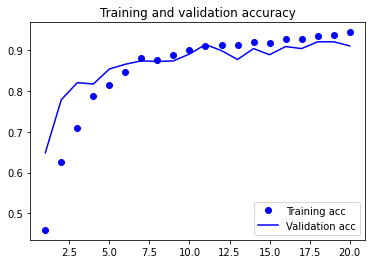

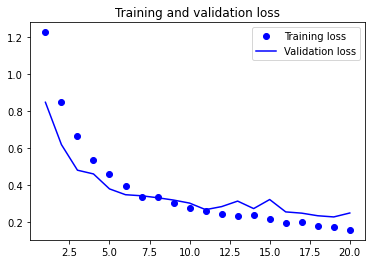

In [ ]:
import matplotlib.pyplot as plt
print(vgg_history.history)
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
actual_model.evaluate(test_gen)

94/94 [==============================] - 22s 228ms/step - loss: 0.1056 - accuracy: 0.9667


[0.10557354986667633, 0.9666666388511658]

# Calculating the time taken for training

In [ ]:
np.average(timetaken.times)

36.48829182386398

# Save VGG19 model

In [ ]:
actual_model.save("food_classifier_vgg.h5")

# ResNet50 model as base model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
import matplotlib.pyplot as plt
import time
import numpy as np

In [ ]:
resnet_image_generator = ImageDataGenerator(validation_split=0.2, preprocessing_function=tf.keras.applications.resnet.preprocess_input, horizontal_flip=True, vertical_flip=True)
resnet_train_gen = resnet_image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224), subset="training")
resnet_val_gen = resnet_image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224), subset="validation")

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
resnet_test_image_generator = ImageDataGenerator(validation_split=0.3, preprocessing_function=tf.keras.applications.resnet.preprocess_input)
resnet_test_gen = resnet_test_image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224))

Found 3000 images belonging to 3 classes.


In [ ]:
resnet_base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet_base_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

# Freeze the ResNet50 model for training

In [ ]:
resnet_base_model.trainable=False
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# Building model with ResNet50 as base model

In [ ]:
actual_model_2 = tf.keras.Sequential()
actual_model_2.add(resnet_base_model)
actual_model_2.add(GlobalAveragePooling2D())
actual_model_2.add(BatchNormalization())
actual_model_2.add(Dense(500, activation="relu"))
actual_model_2.add(Dense(250, activation="relu"))
actual_model_2.add(BatchNormalization())
#actual_model_2.add(Dense(100, activation="relu"))
actual_model_2.add(Dense(50, activation="relu"))
actual_model_2.add(Dropout(0.3))
actual_model_2.add(Dense(resnet_train_gen.num_classes, activation="softmax"))
actual_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 500)               1024500   
                                                                 
 dense_10 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_5 (Batc  (None, 250)             

In [ ]:
optimizer_rms_prop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
actual_model_2.compile(optimizer=optimizer_rms_prop, loss="categorical_crossentropy", metrics=['accuracy'])

# Train model with ResNet50 as base model

In [ ]:
rest_net_history = actual_model_2.fit(resnet_train_gen, epochs=20, workers=8, validation_data=resnet_val_gen, callbacks=[timetaken])

Epoch 1/20
75/75 [==============================] - 21s 219ms/step - loss: 0.7649 - accuracy: 0.6904 - val_loss: 0.5347 - val_accuracy: 0.8417
Epoch 2/20
75/75 [==============================] - 17s 207ms/step - loss: 0.4095 - accuracy: 0.8533 - val_loss: 0.3369 - val_accuracy: 0.8917
Epoch 3/20
75/75 [==============================] - 17s 216ms/step - loss: 0.2970 - accuracy: 0.8858 - val_loss: 0.2790 - val_accuracy: 0.9050
Epoch 4/20
75/75 [==============================] - 17s 209ms/step - loss: 0.2483 - accuracy: 0.9104 - val_loss: 0.2823 - val_accuracy: 0.9017
Epoch 5/20
75/75 [==============================] - 19s 235ms/step - loss: 0.1855 - accuracy: 0.9342 - val_loss: 0.3044 - val_accuracy: 0.9117
Epoch 6/20
75/75 [==============================] - 18s 230ms/step - loss: 0.1718 - accuracy: 0.9442 - val_loss: 0.2671 - val_accuracy: 0.9233
Epoch 7/20
75/75 [==============================] - 17s 209ms/step - loss: 0.1255 - accuracy: 0.9563 - val_loss: 0.2711 - val_accuracy: 0.9133

{'loss': [0.7648558020591736, 0.4095224440097809, 0.29695743322372437, 0.24828612804412842, 0.18551580607891083, 0.17183764278888702, 0.12552283704280853, 0.10644806176424026, 0.09101727604866028, 0.09492732584476471, 0.07269664108753204, 0.07431324571371078, 0.060997333377599716, 0.047935497015714645, 0.04743567481637001, 0.03408375382423401, 0.03949643298983574, 0.026206303387880325, 0.029971711337566376, 0.028880074620246887], 'accuracy': [0.690416693687439, 0.8533333539962769, 0.8858333230018616, 0.9104166626930237, 0.934166669845581, 0.9441666603088379, 0.956250011920929, 0.9629166722297668, 0.9729166626930237, 0.9666666388511658, 0.9750000238418579, 0.9729166626930237, 0.9833333492279053, 0.9866666793823242, 0.9833333492279053, 0.9895833134651184, 0.9895833134651184, 0.9920833110809326, 0.9925000071525574, 0.9900000095367432], 'val_loss': [0.5347292423248291, 0.33686041831970215, 0.2789909839630127, 0.2822795510292053, 0.3044120669364929, 0.267118364572525, 0.2711358666419983, 0.

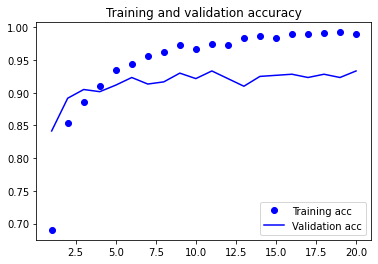

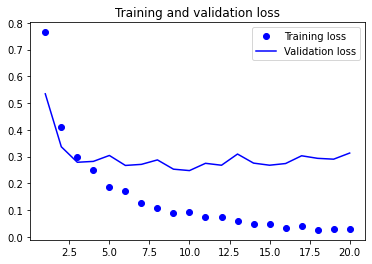

In [ ]:
import matplotlib.pyplot as plt
print(rest_net_history.history)
acc = rest_net_history.history['accuracy']
val_acc = rest_net_history.history['val_accuracy']
loss = rest_net_history.history['loss']
val_loss = rest_net_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
actual_model_2.save("food_classfier_restnet50.h5")

In [ ]:
np.average(timetaken.times)

17.312750279903412

In [ ]:
actual_model_2.evaluate(resnet_test_gen)

94/94 [==============================] - 20s 210ms/step - loss: 0.0686 - accuracy: 0.9843


[0.0686245709657669, 0.984333336353302]

# MobileNetV2 Trained

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import time

In [8]:
mobilenet_image_generator = ImageDataGenerator(validation_split=0.2, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, horizontal_flip=True, vertical_flip=True)
mobilenet_train_gen = mobilenet_image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224), seed=42, class_mode='categorical', subset="training")
mobilenet_val_gen = mobilenet_image_generator.flow_from_directory('/content/drive/MyDrive/food_classifier_model/food-101-subset/images', batch_size=32, shuffle=True, target_size=(224,224), seed=42, class_mode='categorical', subset="validation")

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
train_images, train_labels = mobilenet_train_gen.next()
print(train_labels)
# for i in range(1):
#   plt.imshow(train_images[i].astype('uint8'))
#   plt.show()

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [5]:
mobilenet_base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))
mobilenet_base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [6]:
mobilenet_base_model.trainable=False
mobilenet_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [16]:
actual_model_4 = tf.keras.Sequential()
actual_model_4.add(mobilenet_base_model)
actual_model_4.add(GlobalAveragePooling2D())
actual_model_4.add(Dense(1024, activation="relu"))
# actual_model_4.add(BatchNormalization())
# actual_model_4.add(Dense(640, activation="relu"))
# actual_model_4.add(BatchNormalization())
# actual_model_4.add(Dense(320, activation="relu"))
# actual_model_4.add(BatchNormalization())
# actual_model_4.add(Dense(80, activation="relu"))
# actual_model_4.add(Dropout(0.2))
actual_model_4.add(Dense(mobilenet_train_gen.num_classes, activation="softmax"))
actual_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_8 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 3,572,803
Trainable params: 1,314,819
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
actual_model_4.compile(optimizer=optimizer_adam, loss="categorical_crossentropy", metrics=['accuracy'])

In [10]:
optimizer_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
actual_model_4.compile(optimizer=optimizer_rmsprop, loss="categorical_crossentropy", metrics=['accuracy'])

In [19]:
mobilenet1_history = actual_model_4.fit(mobilenet_train_gen, epochs=20, workers=8, validation_data=mobilenet_val_gen, callbacks=[timetaken])

Epoch 1/20
75/75 [==============================] - 18s 204ms/step - loss: 0.4449 - accuracy: 0.8246 - val_loss: 0.2846 - val_accuracy: 0.9067
Epoch 2/20
75/75 [==============================] - 16s 191ms/step - loss: 0.2277 - accuracy: 0.9175 - val_loss: 0.2489 - val_accuracy: 0.9117
Epoch 3/20
75/75 [==============================] - 15s 190ms/step - loss: 0.1791 - accuracy: 0.9396 - val_loss: 0.2511 - val_accuracy: 0.9117
Epoch 4/20
75/75 [==============================] - 15s 190ms/step - loss: 0.1537 - accuracy: 0.9463 - val_loss: 0.2366 - val_accuracy: 0.9167
Epoch 5/20
75/75 [==============================] - 15s 189ms/step - loss: 0.1209 - accuracy: 0.9617 - val_loss: 0.2369 - val_accuracy: 0.9250
Epoch 6/20
75/75 [==============================] - 15s 189ms/step - loss: 0.1188 - accuracy: 0.9654 - val_loss: 0.2362 - val_accuracy: 0.9200
Epoch 7/20
75/75 [==============================] - 15s 187ms/step - loss: 0.1039 - accuracy: 0.9654 - val_loss: 0.2272 - val_accuracy: 0.9100

{'loss': [0.44487279653549194, 0.22773821651935577, 0.1790803074836731, 0.15366323292255402, 0.12092023342847824, 0.11884483695030212, 0.10390368103981018, 0.09278293699026108, 0.07788018882274628, 0.07250412553548813, 0.06157875061035156, 0.059295278042554855, 0.04994797334074974, 0.04611126706004143, 0.04074585810303688, 0.03362676128745079, 0.03348347172141075, 0.027865396812558174, 0.023697948083281517, 0.024543432518839836], 'accuracy': [0.8245833516120911, 0.9175000190734863, 0.9395833611488342, 0.9462500214576721, 0.9616666436195374, 0.965416669845581, 0.965416669845581, 0.9700000286102295, 0.9770833253860474, 0.9820833206176758, 0.9833333492279053, 0.98416668176651, 0.9895833134651184, 0.9891666769981384, 0.9904166460037231, 0.9954166412353516, 0.9954166412353516, 0.9962499737739563, 0.9979166388511658, 0.997083306312561], 'val_loss': [0.2846236228942871, 0.24889567494392395, 0.25113779306411743, 0.2365511804819107, 0.2369067370891571, 0.23619414865970612, 0.22716112434864044, 

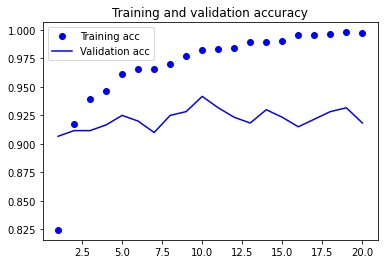

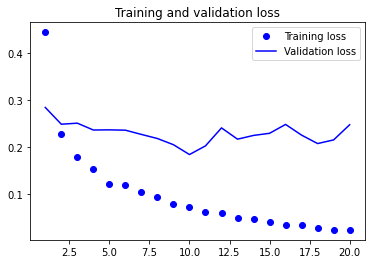

In [20]:
import matplotlib.pyplot as plt
print(mobilenet1_history.history)
acc = mobilenet1_history.history['accuracy']
val_acc = mobilenet1_history.history['val_accuracy']
loss = mobilenet1_history.history['loss']
val_loss = mobilenet1_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
np.average(timetaken.times)

15.994532334804536

In [ ]:
actual_model_4.save("food_classfier_mobilenet.h5")